# Place Reader

The Idea of the project is to train a model to read news articles (first in english) and recognize only from the text where the event happened. I used the OpenAI GPT-2 pretrained model as a starting point and fine tuned it using the Reuters Dataset to teach it how to answer the 'place' question when having an article 'body' as input.  


## Read a file from the reuters dataset
I came across the [reuters dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/) by googling for articles datasets, it is a good starting point for the project as has place information for each article, which is the information the model needs to learn how to read. I downloaded the SGM files locally and loaded one to test the loading pipeline. SGM is a XML-like file with nested information under some 'headers'. I used the SGM functionallity of the BeautifulSoup library to read the SGM file and 'parse' the different headers inside the file. I extracted the body and place of each article and fisrt sorted it in a dictionary.

In [1]:
from bs4 import BeautifulSoup, SoupStrainer
with open('./reuters-dataset/reut2-002.sgm', 'r') as f:
    data = f.read()
    soup = BeautifulSoup(data)
    # each article is embedded in a <REUTERS> object
    articles = soup.findAll('reuters')

# read articles and store in dict
art_dict = {}
for num, article  in enumerate(articles):
    art_dict[num] = {
        'body' : [body.text for body in article.findAll('body')],
        # use the find method for place, an article can have a list of places
        'place' : [place.text for place in article.find('places')]
        }
# show one entry
print(art_dict[0])



{'body': ['Jaguar Plc <JAGR.L> is about to sell its\nnew XJ-6 model on the U.S. And Japanese markets and expects a\nstrong reception based on its success in the U.K., Chairman Sir\nJohn Egan told a news conference.\n    Commenting on an 11 pct growth in 1986 group turnover to\n830.4 mln stg and pre-tax profits at 120.8 mln stg, slightly\nbelow 1985\'s 121.3 mln, Egan said Jaguar aimed at an average\nprofit growth of 15 pct per year. However, the introduction of\nthe new model had kept this year\'s pre-tax profit down.\n    Jaguar starts selling XJ-6 in the U.S. In May and plans to\nsell 25,000 of its total 47,000 production there in 1987.\n    U.S. Sales now account for 65 pct of total turnover,\nfinance director John Edwards said.\n    A U.S. Price for the car has not been set yet, but Edwards\nsaid the relatively high car prices in dollars of West German\ncompetitors offered an "umbrella" for Jaguar. He added the XJ-6\nhad also to compete with U.S. Luxury car producers which would\nr

# Places in the dataset

I converted the dictionary to a pandas dataframe to have a first glance into the data. First thing to do is cleaning the rows without any text or place.

In [2]:
import pandas as pd
import numpy as np

# for generating the training text I am interested in having the places not as a list of strings but as a string itself e.g. 'usa, germany, china'. I would expect the model to give me an answer in the same format.
text_df = pd.DataFrame(data=(('. '.join(value.get('body')), ', '.join(value.get('place'))) for key, value in art_dict.items()), columns=('body', 'places'))

# remove rows with empty body or places
text_df.replace('', np.NaN, inplace=True)
# dropna with inplace = True to save the change in the dataframe
text_df.dropna(axis=0, inplace=True)

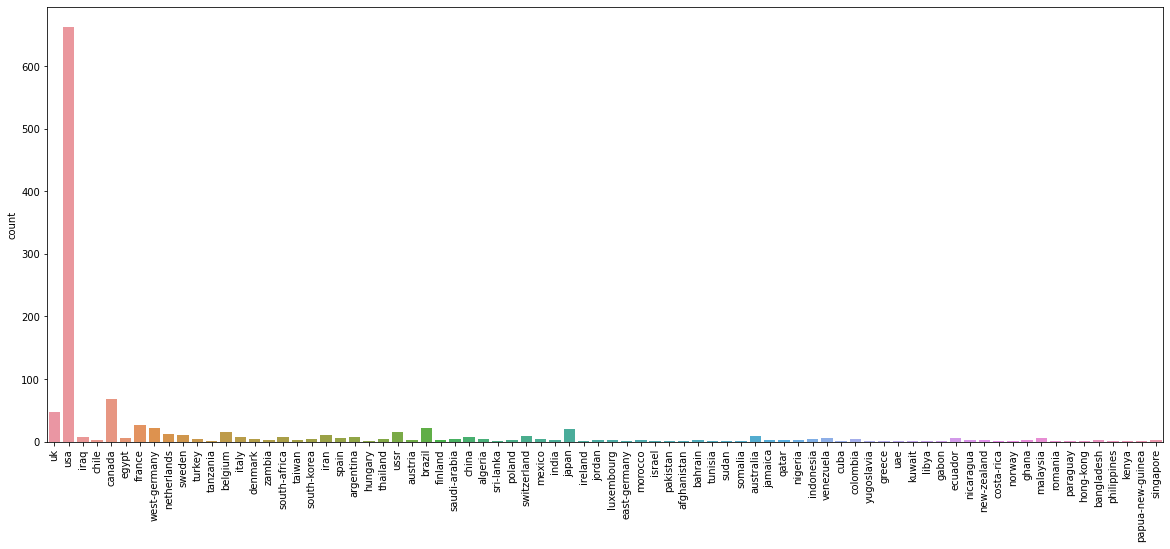

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# get a flat list of places in a dataset
places_list = [str(places).split(', ') for places in text_df["places"]]
places_flatt = [item for sublist in places_list for item in sublist]

plt.figure(figsize=(20, 8))
hist = sns.countplot(x=places_flatt)
plt.xticks(rotation='vertical')
plt.show()

The dataset, or at least this file in the dataset has much more articles about the USA than about any other country. I would have expected reuters to have much more international aritcles but well, it is written it english so not that big of a surprise. The model would probably perform really good at recognizing that an articles's 'place' is the USA but not so good when the 'place' is different.
In a further step I would look for a more balanced dataset and even look for getting specific places, like regions or towns. That would be for sure more challenging for a model.

# Write text file as base dataset  
Divide the dataset into training and test set. Afterwards write body and place as '<|startoftext|>' + '[CONTEXT]' + article body + '[PLACE]' + article place + '<|endoftext|>'. This tags highlight the order in which the model should read and later complete the information when asked for it. It should learn that after the [PLACE] indicator, you should write the place of the article.  
All articles are concatenated together in a single string and then stored for further use.

In [5]:

from sklearn.model_selection import train_test_split

def build_text_files(df, file_name):
    with open(file_name, "w") as f:
        d_text = ''
        
        #for item in art_d.keys():
        context = "<|startoftext|>\n[CONTEXT]:" + df['body']
        place = "\n[PLACE]:" + df['places']+ "\n<|endoftext|>\n"
        d_text = context + place + " "
        out_text = '\n '.join(d_text.to_list())

        f.write(out_text)


train, test = train_test_split(text_df,test_size=0.15)

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))


Train dataset length: 766
Test dataset length: 136


# Train Model
I started playing with the Hugging-Face transformers package (based on this notebook) which offers an easy to use playground to implement and fine tune the language models available with Hugging-Face. After playing for a while I decided I wanted to implement my model using native tensorflow to have a deeper look into the model. The methods ofered by hugging face can also be fine tuned and set with the parameters you wish. My thought was to use this model to train tensorflow rather than becoming an 'expert' in hugging face. Focus on one thing at a time.

In [2]:
from transformers import GPT2Tokenizer

# Define variables to load input data
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

## Build TextDataset
The text needs to be transformed into a tensor object (TF Dataset) that the model can take as input. Furthermore, the shape of the dataset has to be consistent, each input vector needs to have the same length, thats why the text (or the equivalent collection of tokens) is divided into blocks of the same length and then into batches that tensorflow can read in parallel.  
This code is based on this article https://towardsdatascience.com/train-gpt-2-in-your-own-language-fc6ad4d60171. It was crucial to get the right parameter shape to fit the TFGPT2LMHeadModel with native tensorflow.



In [3]:
import tensorflow as tf

def load_dataset(
    file_path,
    tokenizer,
    block_size,
    batch_size,
    buffer_size
    ):
    with open(file_path, 'r') as f:
        text = f.read()
    # Use the imported GOT-2 tokenizer
    text_tokenized = tokenizer.encode(text)
    # make tensorflow dataset
    examples = []

    for i in range(0, len(text_tokenized) - block_size + 1, block_size):
        examples.append(text_tokenized[i:i + block_size])
    inputs, labels = [], []
    # Tensorflow Dataset needs to have an input and output(x,y)
    for ex in examples:
        inputs.append(ex[:-1])
        labels.append(ex[1:])

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

    return dataset


block_size =128 # articles are longer, could try a 500 block size
BATCH_SIZE = 16
BUFFER_SIZE = 1000

train_dataset = load_dataset(train_path, tokenizer=tokenizer,block_size=block_size, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
test_dataset = load_dataset(test_path, tokenizer=tokenizer,block_size=block_size, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

Token indices sequence length is longer than the specified maximum sequence length for this model (192621 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
Got warning: 'Token indices sequence length is longer than the specified maximum sequence length for this model (192621 > 1024). Running this sequence through the model will result in indexing errors'
Define the vocab length, or number of tokens in the model config

In [28]:
# check the shape of the input dataset
print(train_dataset.txt)
print(list(train_dataset.as_numpy_iterator())[0])

(array([[17329,   352,    13, ...,  3691, 18038,    13],
       [  307, 17955,   523, ...,  2237,   269,   912],
       [  379, 10068,  6082, ...,   262,  2493,   286],
       ...,
       [  481,  8749,   262, ...,   257,   198,  5162],
       [ 6489, 11598,  5974, ...,   220,   220,   220],
       [ 2756, 12897,   198, ...,   198,   265,   257]], dtype=int32), array([[  352,    13,  3459, ..., 18038,    13,   198],
       [17955,   523,   326, ...,   269,   912,  3691],
       [10068,  6082,   286, ...,  2493,   286,  4849],
       ...,
       [ 8749,   262,  6341, ...,   198,  5162,  4741],
       [11598,  5974, 22064, ...,   220,   220,   317],
       [12897,   198,  6738, ...,   265,   257,  1803]], dtype=int32))


## Define the model parameters

Training docu for TFGPT2LMHeadModel: https://huggingface.co/transformers/training.html

In [4]:
from transformers import TFGPT2LMHeadModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = TFGPT2LMHeadModel.from_pretrained("gpt2-medium")
optimizer = Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# Save and Train the Model

In [5]:
from tensorflow.keras.callbacks import TensorBoard

tb_callback = TensorBoard(
        log_dir='./logs/gpt2-places',
        histogram_freq=1,
        write_graph=True
    )

# The trick with the loss parameter is fundamental to match the shape in the GPT-2 Model
model.compile(
    optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric]
    )
print(model)

model.fit(
    train_dataset,
    validation_data=test_dataset,
    verbose=1,
    epochs=2,
    batch_size=128,
    callbacks=tb_callback
)
model.save_pretrained('./gpt2-places/')

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
94/94 [==============================] - 4244s 45s/step - loss: 3.1802 - logits_loss: 3.1802 - logits_accuracy: 0.4385 - past_key_values_1_accuracy: 0.0019 - past_key_values_2_accuracy: 0.0016 - past_key_values_3_accuracy: 9.9233e-04 - past_key_val

# Test the model

In [1]:
from transformers import pipeline

locator = pipeline('text-generation', model='./gpt2-places', tokenizer='gpt2')


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt2-places.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt2-places.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


 Get some random news article

In [7]:
test = "During a surge in attacks on Asian-Americans last spring, Andrew Yang — then recently off the 2020 presidential campaign trail — wrote an op-ed suggesting that 'we Asian-Americans need to embrace and show our Americanness in ways we never have before.' To many Asian-Americans, the message seemed to place yet another burden on victims, and it stung. One year later, as Mr. Yang hopes to make history as New York City’s first Asian-American mayor, some New Yorkers have not forgotten that op-ed, or their sense that Mr. Yang’s remarks during the presidential campaign — describing himself as “an Asian man who likes math,” for instance — could feed stereotypical tropes. But many Asian-Americans also see in his candidacy an opportunity for representation at the highest level of city government, an increasingly meaningful metric amid violent attacks on Asian-Americans in New York and across the nation, including the fatal shootings in the Atlanta area last week that left eight people dead, six of them women of Asian descent. 'I grew up Asian-American in New York, and I was always accustomed to a certain level of bullying, of racism, but it took a form of mockery, of invisibility, of disdain,' an emotional Mr. Yang said at a news conference in Times Square the next day. 'That has metastasized into something far darker. You can feel it on the streets of New York.'"
test_text = '<|startoftext|>\n[CONTEXT]:' + test + '\n[PLACE]:'

 ### Get Result for test

In [8]:
result = locator(test_text, max_length=500)[0]['generated_text']
print(result)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
<|startoftext|>
[CONTEXT]:During a surge in attacks on Asian-Americans last spring, Andrew Yang — then recently off the 2020 presidential campaign trail — wrote an op-ed suggesting that 'we Asian-Americans need to embrace and show our Americanness in ways we never have before.' To many Asian-Americans, the message seemed to place yet another burden on victims, and it stung. One year later, as Mr. Yang hopes to make history as New York City’s first Asian-American mayor, some New Yorkers have not forgotten that op-ed, or their sense that Mr. Yang’s remarks during the presidential campaign — describing himself as “an Asian man who likes math,” for instance — could feed stereotypical tropes. But many Asian-Americans also see in his candidacy an opportunity for representation at the highest level of city government, an increasingly meaningful metric amid violent attacks on Asian-Americans in New York and across the 

In [2]:
test_2 = "South African Adrian Nel is one of the victims of a brutal insurgency being waged by militant Islamists in northern Mozambique. Dozens of bodies have been seen but few details have emerged about the other casualties. Mr Nel would have celebrated his 41st birthday on 1 April. But his body now lies in a mortuary in Pemba - a coastal city in Mozambique's resource-rich Cabo Delgado province. The region has become the latest front line in the global war being waged by militant Islamists. On Wednesday, hundreds of those militants stormed the town of Palma. Mr Nel was among dozens of people who were trying to flee the attack. His body was recovered by fleeing survivors - including his father and younger brother. Speaking to the BBC from her home in South Africa, Nel's mother, Meryl Knox, said her son leaves behind his French-Canadian wife and three children - a 10-year-old boy, and two girls, aged six and two. 'He was an absolutely beautiful father, and a beautiful person all round,' she said. 'There's been so many messages of comfort from people that have known him throughout the years. And he will be terribly, terribly missed.' Mr Nel was a commercial diver who had lost his job in South Africa because of the devastating impact of Covid-19. He moved to Mozambique in January to join his father and younger brother in the construction industry, building workers' accommodation camps in Palma, which has become the hub of a burgeoning gas industry following the offshore discovery of one of the largest natural gas fields in Africa. A mere three months later, he faced a cruel death, having been shot by militants who had carried out a four-day assault on the town, targeting shops, banks, a military barracks and the Amarula Hotel, where Nel, his father and younger brother had taken refuge along with other expatriates."
test2_text = '<|startoftext|>\n[CONTEXT]:' + test_2 + '\n[PLACE]:'

In [3]:
result2 = locator(test2_text, max_length=500)[0]['generated_text']
print(result2)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
<|startoftext|>
[CONTEXT]:South African Adrian Nel is one of the victims of a brutal insurgency being waged by militant Islamists in northern Mozambique. Dozens of bodies have been seen but few details have emerged about the other casualties. Mr Nel would have celebrated his 41st birthday on 1 April. But his body now lies in a mortuary in Pemba - a coastal city in Mozambique's resource-rich Cabo Delgado province. The region has become the latest front line in the global war being waged by militant Islamists. On Wednesday, hundreds of those militants stormed the town of Palma. Mr Nel was among dozens of people who were trying to flee the attack. His body was recovered by fleeing survivors - including his father and younger brother. Speaking to the BBC from her home in South Africa, Nel's mother, Meryl Knox, said her son leaves behind his French-Canadian wife and three children - a 10-year-old boy, and two girls,

## First Results
News in USA or UK get predicted easily. It has a harder time when the article is from another place

# Ideas
- Model works well with countries. Get a dataset where more specific places (city, towns, streets) are saved as features.
  
cleaning Ideas
- Write an only place output from the pipeline
- remove the Reuter\n\x03 ending of each article
- Add special tokens to tokenizer, define eos_token_id
- Add a small description to the readme file
- Write results based on the tensorboard of the model's training
- recognize local GPU for faster training with Tensorflow

Develop Ideas
- Plot a map of the place of article (articles of the day in a webpage)
- Train in spanish